<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/v1/states/daily.json"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))
dfCovidtracking.set_index(['date'], inplace=True)


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/06-12-2020.csv"


dfJHUData = pd.read_csv(jhurl, header=0, usecols=[0,1,2,3,4,5,6,7,8,9,10,11],
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [6]:
print("US Summary")
dfCovidtracking.groupby(by='date').sum()[-14:][['positive', 'death', 'positiveIncrease', 'deathIncrease']]

US Summary


,positive,death,positiveIncrease,deathIncrease
date,,,,
2020-05-31,1790749,98927,22085,655
2020-06-01,1806943,99405,16194,478
2020-06-02,1830544,100562,23601,1157
2020-06-03,1850582,101531,20038,969
2020-06-04,1871150,102407,20568,876
2020-06-05,1894449,103255,23299,848
2020-06-06,1917160,103972,22711,717
2020-06-07,1936717,104432,19557,460
2020-06-08,1953730,105087,17013,655


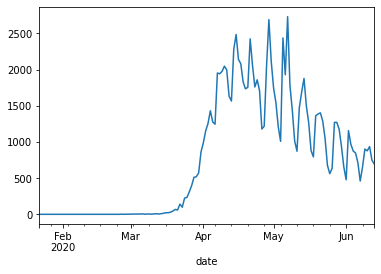

In [7]:
dfCovidtracking.groupby(by='date').sum().deathIncrease.plot.line()

In [8]:
dfCovidtracking.loc[dfCovidtracking.state=='CA'].groupby(by='date').sum()[['positive', 'death', 'positiveIncrease', 'deathIncrease']].tail()

,positive,death,positiveIncrease,deathIncrease
date,,,,
2020-06-09,133489,4697,2170,44
2020-06-10,136191,4776,2702,79
2020-06-11,139281,4881,3090,105
2020-06-12,141983,4943,2702,62
2020-06-13,145643,4989,3660,46


In [9]:
dfctd_state_curr = dfCovidtracking.loc[dfCovidtracking.index.max()] \
  .rename(columns={'positive':'total_positive'}) \
  .set_index('state') 

print(f"Total positive cases = {dfctd_state_curr.total_positive.sum()}")
print(f"Total deaths = {dfctd_state_curr.death.sum()}")
  
dfctd_state_curr.sort_values(by='total_positive', ascending=False).head(5)

Total positive cases = 2063789
Total deaths = 109249


,total_positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NY,382630,2489610,0,1734.0,89995.0,517.0,0.0,360.0,0.0,68584.0,A,6/12/2020 00:00,2020-06-12T00:00:00Z,06/11 20:00,24527,89995.0,2020-06-12T00:00:00Z,0.0,0.0,0.0,382630.0,36,916,69924,2872240,2872240,70840,2872240,32,0,fc7045a058c6900c23e63fea1169e0001b87fe29,0,0,0,0,0,
NJ,166605,911610,0,1395.0,18707.0,409.0,0.0,279.0,0.0,28606.0,A+,6/13/2020 13:00,2020-06-13T13:00:00Z,06/13 09:00,12589,18707.0,2020-06-13T13:00:00Z,0.0,0.0,0.0,166605.0,34,441,22378,1078215,1078215,22819,1078215,100,100,8465dafe0081d6ed37182a58193a5dcac245117c,0,0,0,0,0,
CA,145643,2578750,0,4411.0,0.0,1313.0,0.0,0.0,0.0,0.0,B,6/13/2020 00:00,2020-06-13T00:00:00Z,06/12 20:00,4989,0.0,2020-06-13T00:00:00Z,2724393.0,0.0,0.0,145643.0,06,3660,58475,2724393,2724393,62135,2724393,46,0,0ad5825c937c99da65bdb60333b4625c91134585,0,0,0,0,0,
IL,132732,1037074,0,2117.0,0.0,610.0,0.0,352.0,0.0,0.0,A,6/13/2020 00:00,2020-06-13T00:00:00Z,06/12 20:00,6470,0.0,2020-06-13T00:00:00Z,1168945.0,0.0,0.0,131871.0,17,673,21171,1169806,1169806,21844,1169806,29,0,04842b2d21a25d8934c1be68f184acdb3042710e,0,0,0,0,0,
MA,105395,598201,0,1069.0,10772.0,249.0,0.0,162.0,0.0,0.0,A+,6/13/2020 10:00,2020-06-13T10:00:00Z,06/13 06:00,7576,10772.0,2020-06-13T10:00:00Z,0.0,0.0,0.0,101070.0,25,336,9901,703596,703596,10237,703596,38,46,808f0711af07248b12ea8bc421138d970f4dcb13,0,0,0,0,0,


In [0]:
curr_state = 'CA'
gbUSA = dfCovidtracking.groupby(['date'])
gbState = dfCovidtracking[dfCovidtracking.state==curr_state].groupby(['date'])

cols = ['positive', 'totalTestResultsIncrease', 'death', 'positiveIncrease','deathIncrease']

dfUSAPos = gbUSA[cols].sum().reset_index().copy()
dfStatePos = gbState[cols].sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 

dfUSAPos['pos_pct']= dfUSAPos.positive/dfctd_state_curr.total_positive.sum()
dfStatePos['pos_pct']=dfStatePos.positive/dfctd_state_curr.loc[curr_state].total_positive

In [11]:
dfUSAPos[-7:]

,date,positive,totalTestResultsIncrease,death,positiveIncrease,deathIncrease,pos_pct
137,2020-06-07,1936717,446651,104432,19557,460,0.938428
138,2020-06-08,1953730,402117,105087,17013,655,0.946671
139,2020-06-09,1970765,413766,105989,17035,902,0.954926
140,2020-06-10,1991527,419468,106867,20762,878,0.964986
141,2020-06-11,2013778,446765,107803,22251,936,0.975767
142,2020-06-12,2037530,583961,108554,23752,751,0.987276
143,2020-06-13,2063789,523042,109249,26259,695,1.000000


In [12]:
dfStatePos[-7:]

,date,positive,totalTestResultsIncrease,death,positiveIncrease,deathIncrease,pos_pct
95,2020-06-07,128812,53918,4626,2796,67,0.884437
96,2020-06-08,131319,68972,4653,2507,27,0.901650
97,2020-06-09,133489,55055,4697,2170,44,0.916549
98,2020-06-10,136191,54553,4776,2702,79,0.935102
99,2020-06-11,139281,56849,4881,3090,105,0.956318
100,2020-06-12,141983,64611,4943,2702,62,0.974870
101,2020-06-13,145643,62135,4989,3660,46,1.000000


In [13]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-09,1970765,19096303,1661,30547.0,219089.0,6450.0,9141.0,3090.0,771.0,524855.0,105989,219089.0,12040910.0,272852.0,3448405.0,1836300.0,17035,396731,21068729,21067068,413766,21067068,902,1508,0,0,0,0,0
2020-06-10,1991527,19495009,1737,30203.0,220602.0,6242.0,9225.0,3020.0,780.0,533504.0,106867,220602.0,11244005.0,276235.0,3496690.0,1852393.0,20762,398706,21488273,21486536,419468,21486536,878,1513,0,0,0,0,0
2020-06-11,2013778,19919523,1816,29064.0,221983.0,6067.0,9295.0,2886.0,792.0,540292.0,107803,221983.0,11385094.0,278760.0,3540246.0,1900910.0,22251,424514,21935117,21933301,446765,21933301,936,1381,0,0,0,0,0
2020-06-12,2037530,20479732,1783,28524.0,223281.0,6012.0,9373.0,2734.0,814.0,547386.0,108554,223281.0,12263513.0,316795.0,4169383.0,1920996.0,23752,560209,22519045,22517262,583961,22517262,751,1298,0,0,0,0,0
2020-06-13,2063789,20976515,1698,27902.0,224420.0,5878.0,9430.0,2726.0,830.0,556606.0,109249,224420.0,12530491.0,323040.0,4246449.0,1948587.0,26259,496783,23042002,23040304,523042,23040304,695,1139,0,0,0,0,0


In [14]:
gbState.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-09,133489,2352756,0,4583.0,0.0,1345.0,0.0,0.0,0.0,0.0,4697,0.0,2486245.0,0.0,0.0,133489.0,2170,52885,2486245,2486245,55055,2486245,44,0,0,0,0,0,0
2020-06-10,136191,2404607,0,4719.0,0.0,1326.0,0.0,0.0,0.0,0.0,4776,0.0,2540798.0,0.0,0.0,136191.0,2702,51851,2540798,2540798,54553,2540798,79,0,0,0,0,0,0
2020-06-11,139281,2458366,0,4534.0,0.0,1325.0,0.0,0.0,0.0,0.0,4881,0.0,2597647.0,0.0,0.0,139281.0,3090,53759,2597647,2597647,56849,2597647,105,0,0,0,0,0,0
2020-06-12,141983,2520275,0,4480.0,0.0,1310.0,0.0,0.0,0.0,0.0,4943,0.0,2662258.0,0.0,0.0,141983.0,2702,61909,2662258,2662258,64611,2662258,62,0,0,0,0,0,0
2020-06-13,145643,2578750,0,4411.0,0.0,1313.0,0.0,0.0,0.0,0.0,4989,0.0,2724393.0,0.0,0.0,145643.0,3660,58475,2724393,2724393,62135,2724393,46,0,0,0,0,0,0


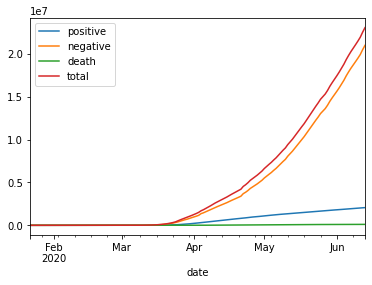

In [15]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

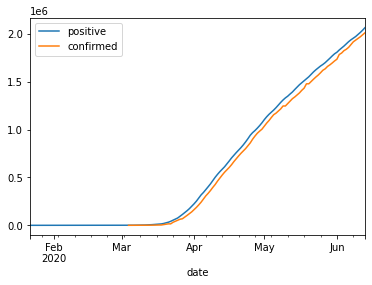

In [16]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

# John Hopkins Data


In [17]:
dfData = dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()
print(dfData)
print(f"IFR based on JHU Data: {dfData.dead/dfData.confirmed*100:.2f}%")

confirmed    2048986
dead          114669
dtype: int64
IFR based on JHU Data: 5.60%


In [18]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    146659
dead           4978
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [20]:
dfJHUData.head()

,FIPS,city,state,country,last_update,lat,lon,confirmed,dead,recovered,active,key
0,45001.0,Abbeville,South Carolina,US,2020-06-13 03:33:14,34.223334,-82.461707,62,0,0,62,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-06-13 03:33:14,30.295065,-92.414197,535,31,0,504,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-06-13 03:33:14,37.767072,-75.632346,987,13,0,974,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-06-13 03:33:14,43.452658,-116.241552,877,22,0,855,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-06-13 03:33:14,41.330756,-94.471059,11,0,0,11,"Adair, Iowa, US"


In [21]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                2048986
Brazil             828810
Russia             510761
India              297535
United Kingdom     294402
Spain              243209
Italy              236305
Peru               214788
France             193220
Germany            187226
Name: confirmed, dtype: int64

In [22]:
dfctd_state_curr.head()

,total_positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AK,654,71149,0,12.0,0.0,0.0,0.0,2.0,0.0,405.0,A,6/13/2020 00:00,2020-06-13T00:00:00Z,06/12 20:00,12,0.0,2020-06-13T00:00:00Z,71803.0,0.0,0.0,0.0,02,29,894,71803,71803,923,71803,0,0,fd7214547e7a6c8b8153a5a26cb57fa373d2653e,0,0,0,0,0,
AL,24601,268651,0,622.0,2241.0,0.0,672.0,0.0,395.0,13508.0,B,6/13/2020 11:00,2020-06-13T11:00:00Z,06/13 07:00,773,2241.0,2020-06-13T11:00:00Z,0.0,0.0,0.0,24221.0,01,891,5976,293252,293252,6867,293252,4,39,fbbaf3e55677cc7d1eed550a654b675e362268f7,0,0,0,0,0,
AR,11547,175470,0,203.0,979.0,0.0,0.0,49.0,160.0,7607.0,A,6/13/2020 00:00,2020-06-13T00:00:00Z,06/12 20:00,176,979.0,2020-06-13T00:00:00Z,0.0,0.0,0.0,11547.0,05,0,5895,187017,187017,5895,187017,0,18,51267156707bdb86f0a40abe6d5a71bc07b53e10,0,0,0,0,0,
AS,0,174,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C,6/1/2020 00:00,2020-06-01T00:00:00Z,05/31 20:00,0,0.0,2020-06-01T00:00:00Z,0.0,0.0,0.0,0.0,60,0,0,174,174,0,174,0,0,6de298564b96651ea5ba89430d7ace0132db497f,0,0,0,0,0,
AZ,34458,293939,0,1412.0,3692.0,447.0,0.0,309.0,0.0,6209.0,A+,6/13/2020 00:00,2020-06-13T00:00:00Z,06/12 20:00,1183,3692.0,2020-06-13T00:00:00Z,328085.0,0.0,0.0,34146.0,04,1540,15621,328397,328397,17161,328397,39,70,25524dee11d0758cb69b3a22cd09636269c5dc94,0,0,0,0,0,


In [0]:
dfState = dfCovidtracking.reset_index()[['date','state','positive', 'death']].set_index('state') \
  .join(dfctd_state_curr.total_positive)

In [0]:
dfState['pct']=dfState.positive/dfState.total_positive

In [25]:
dfState.loc['HI'].head(14)


,date,positive,death,total_positive,pct
state,,,,,
HI,2020-06-13,706,17,706,1.000000
HI,2020-06-12,692,17,706,0.980170
HI,2020-06-11,685,17,706,0.970255
HI,2020-06-10,682,17,706,0.966006
HI,2020-06-09,676,17,706,0.957507
HI,2020-06-08,675,17,706,0.956091
HI,2020-06-07,673,17,706,0.953258
HI,2020-06-06,664,17,706,0.940510
HI,2020-06-05,655,17,706,0.927762


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

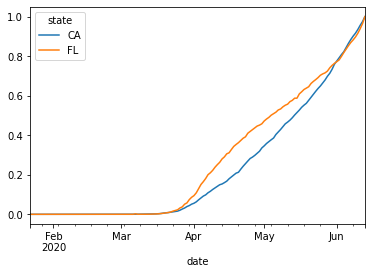

In [27]:
x = res.loc[:, ['CA','FL']].plot.line()

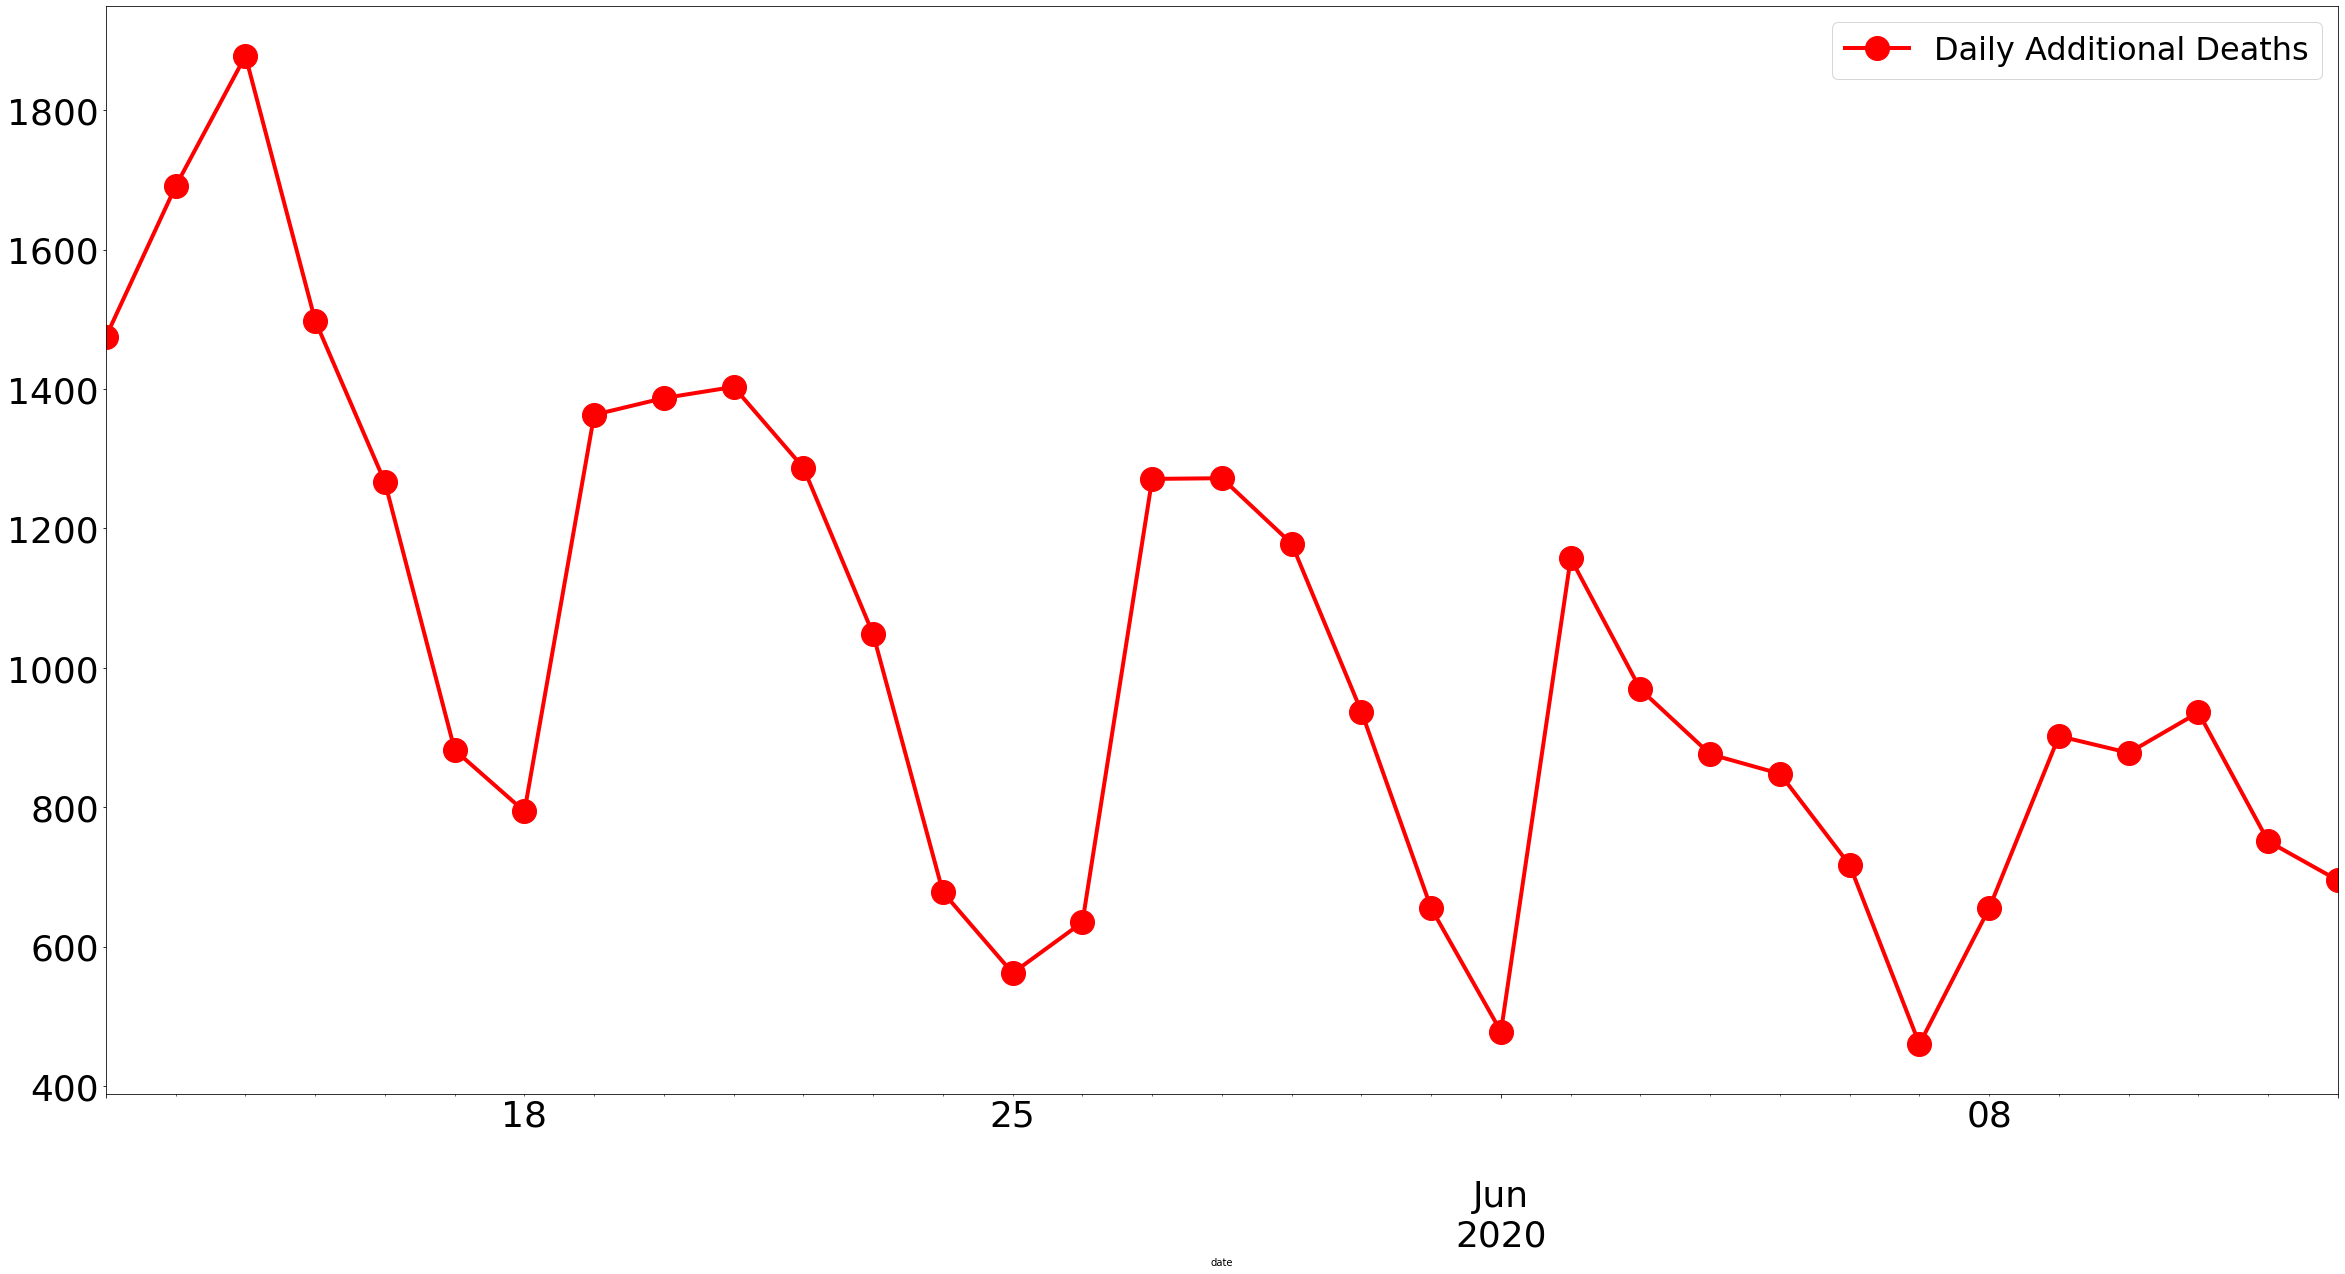

In [28]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()[-33:].deathIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Deaths'],fontsize=32)


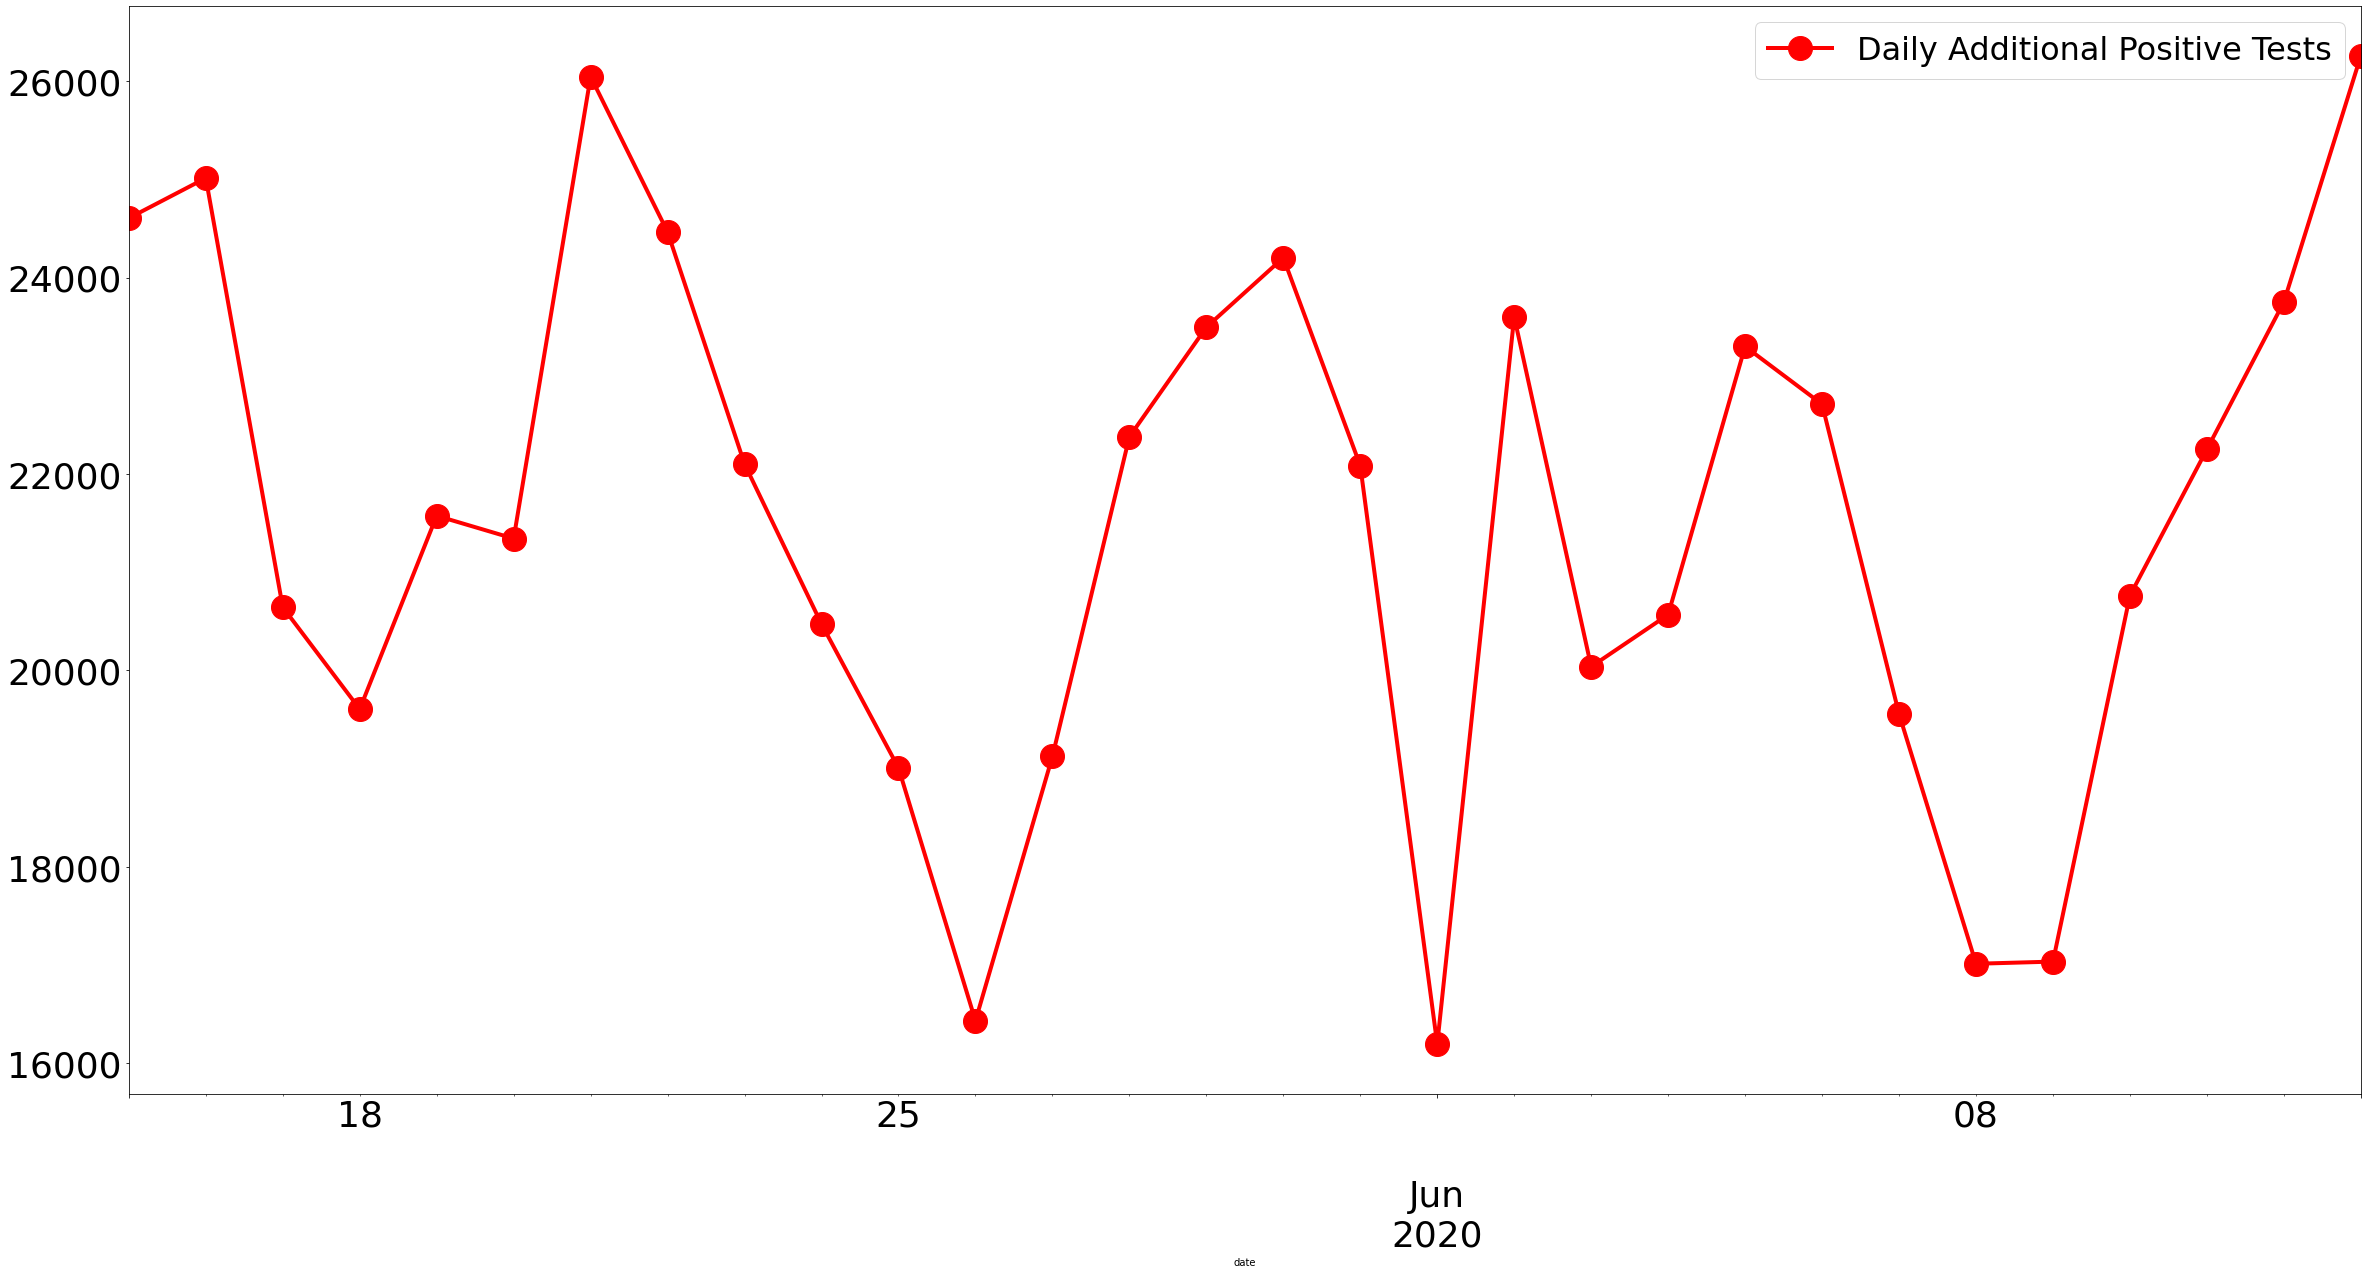

In [29]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()

chart = y1[-30:].positiveIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Positive Tests'],fontsize=32)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfByWeekYear = dfCovidtracking[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=getWeek)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfDoW = dfCovidtracking[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=lambda x: x.dayofweek)


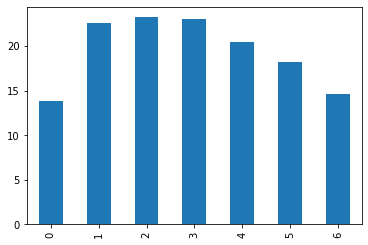

In [32]:
dfDoW.mean().deathIncrease.plot.bar()



In [33]:
dfByWeekYear.sum()[-7:]

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
202018,12575,24581,1470237,191087,1661324
202019,12344,18998,1742137,171552,1913689
202020,9562,12129,2315428,157984,2473412
202021,7960,15648,2618181,155611,2773792
202022,6510,26480,2622280,146726,2769006
202023,5505,6823,3069113,145968,3215081
202024,4817,7514,2662047,127072,2789119


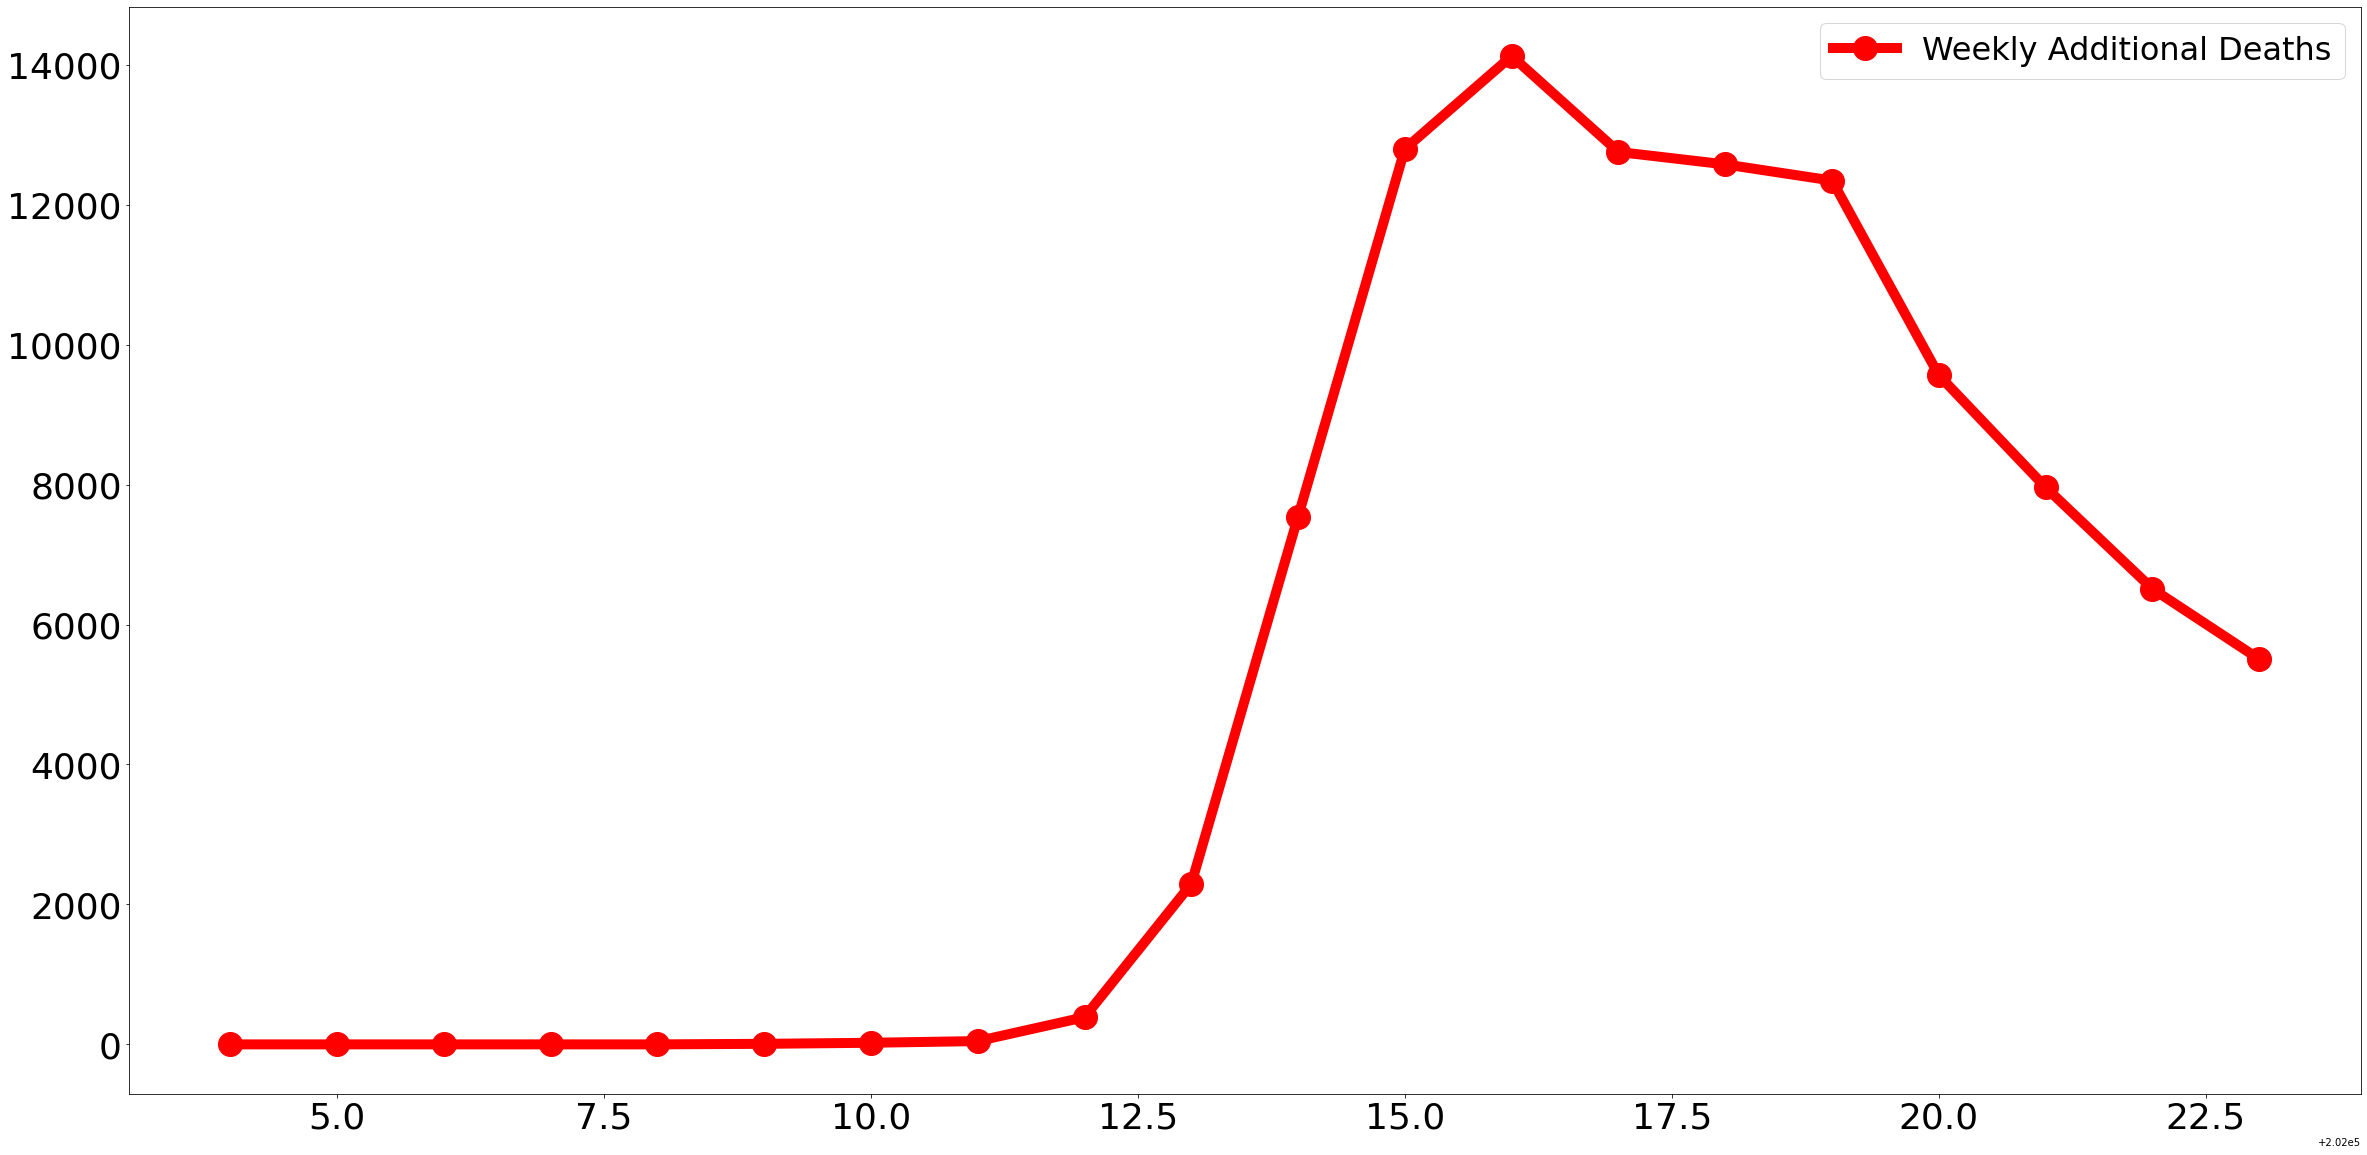

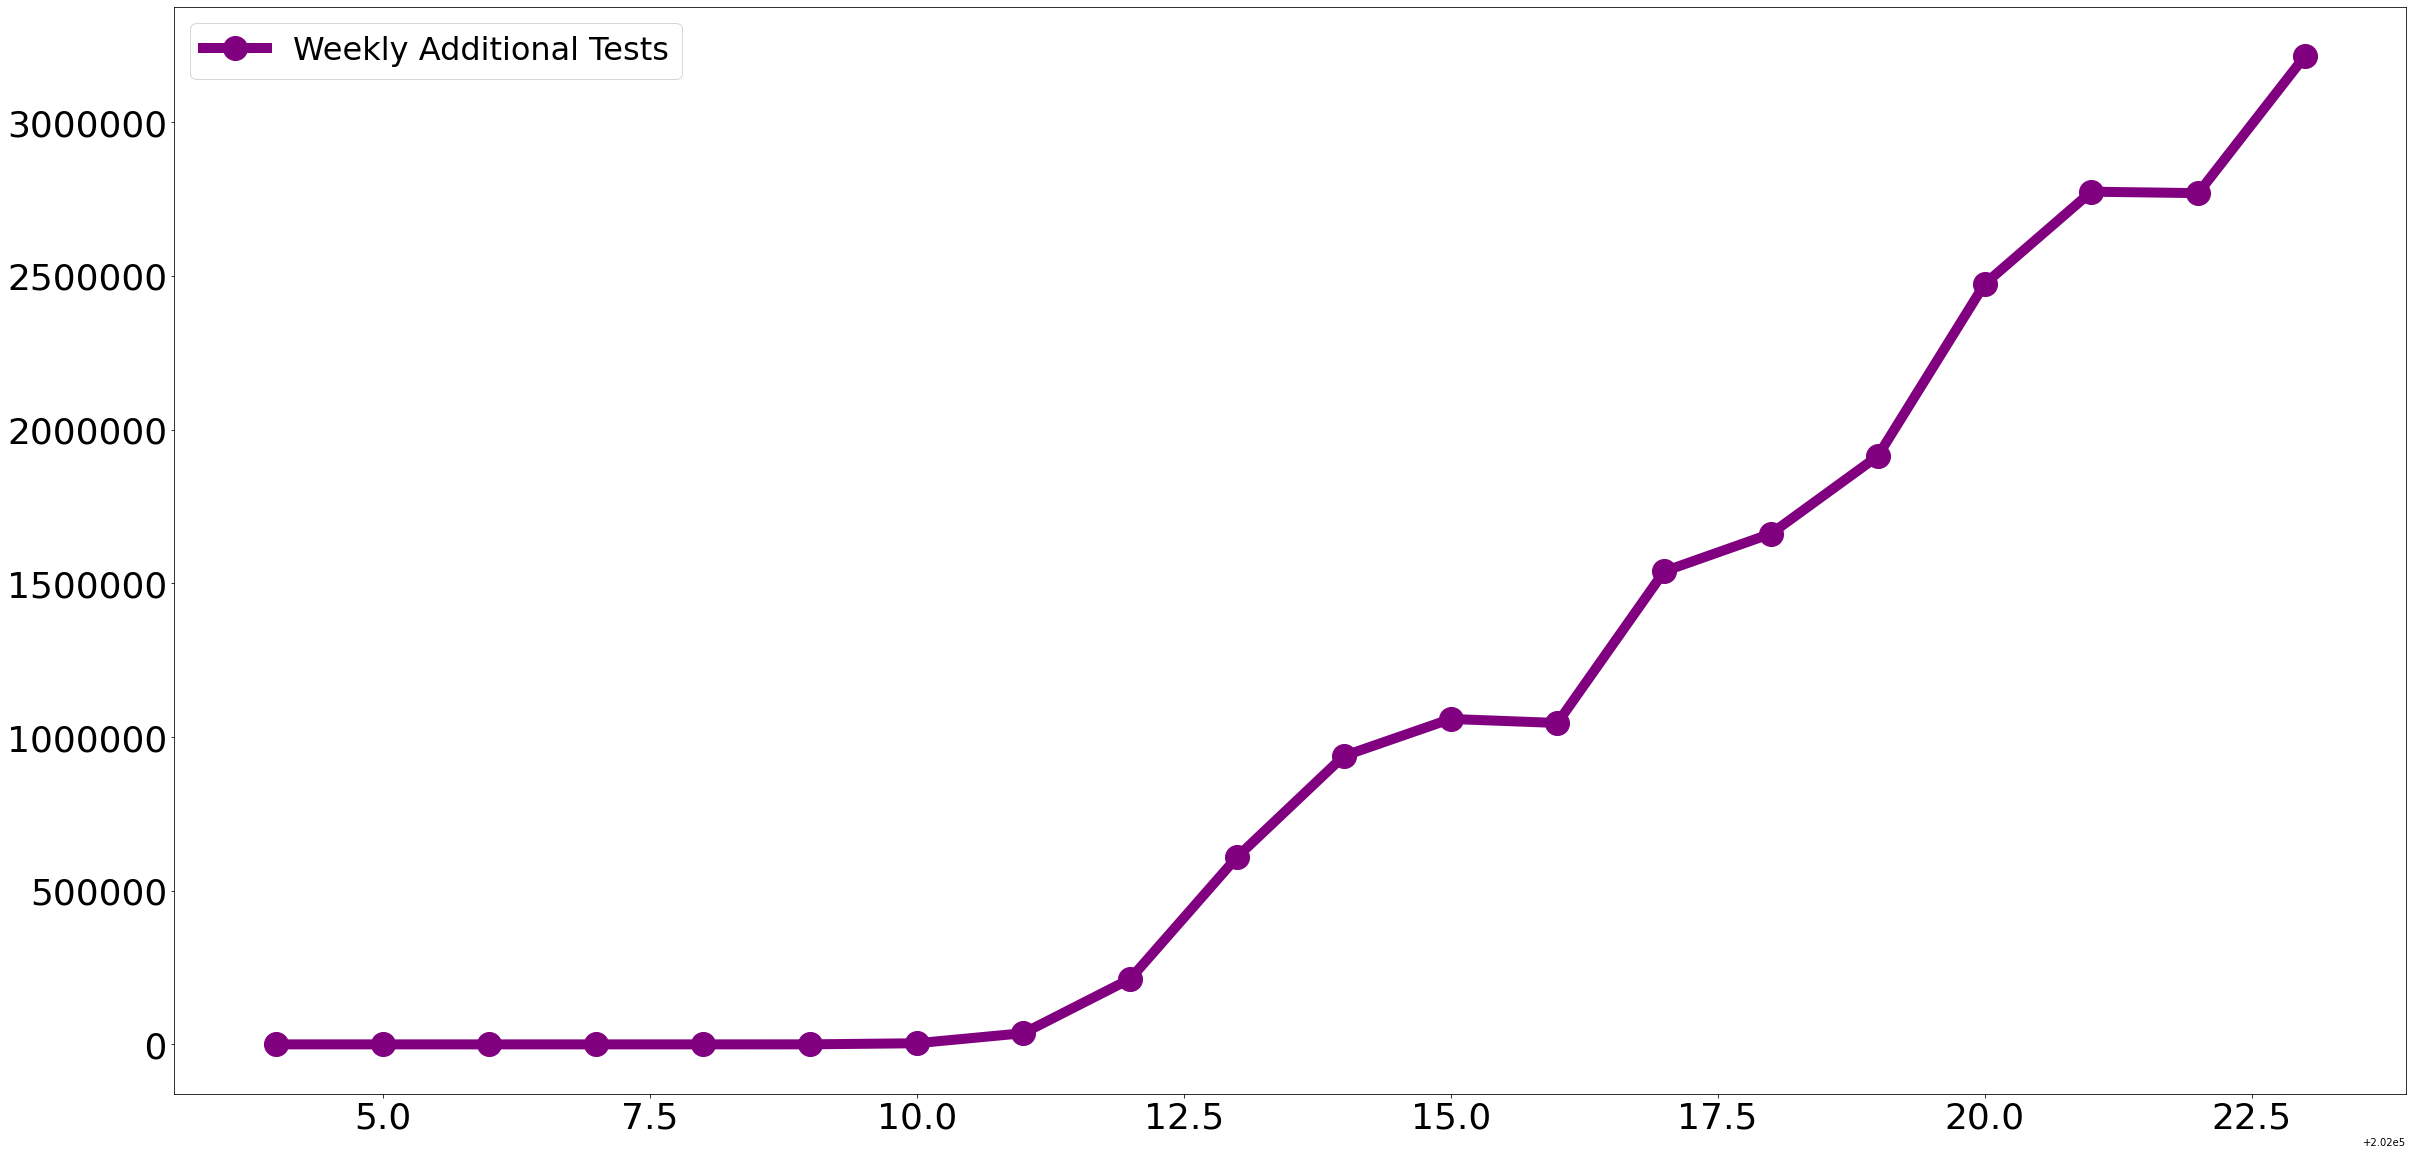

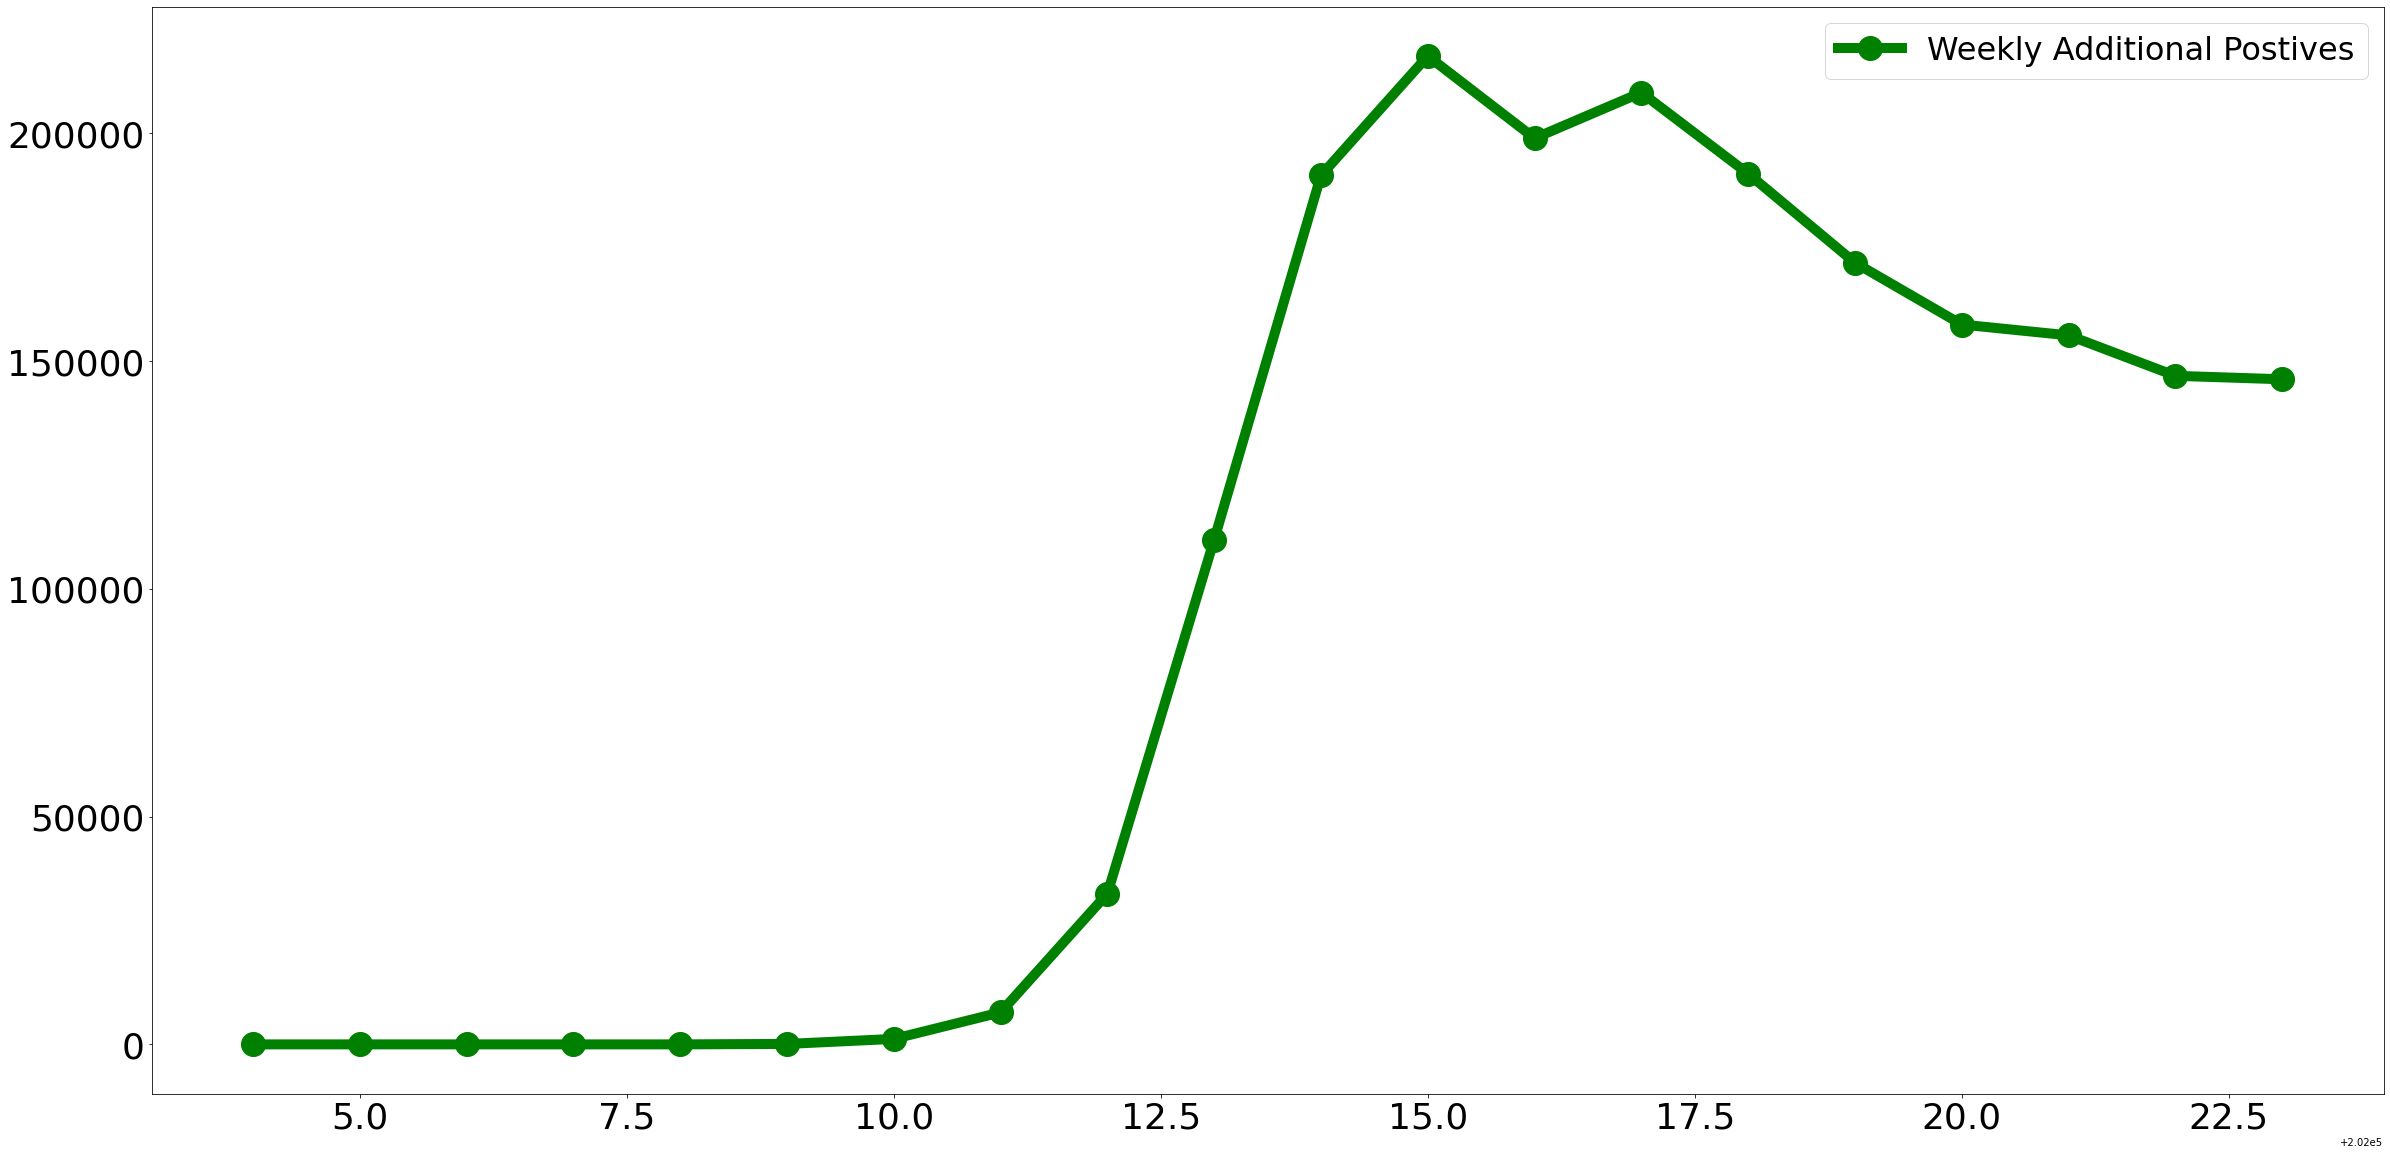

In [34]:
import matplotlib.ticker as ticker
plt1 = dfByWeekYear.sum()[:-1][['deathIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='red')
plt1.legend(['Weekly Additional Deaths'],fontsize=32)
plt2 = dfByWeekYear.sum()[:-1][['totalTestResultsIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='purple')
plt2.legend(['Weekly Additional Tests'],fontsize=32)

plt2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%6.0d'))
    
plt3 = dfByWeekYear.sum()[:-1][['positiveIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='green')
plt3.legend(['Weekly Additional Postives'],fontsize=32)

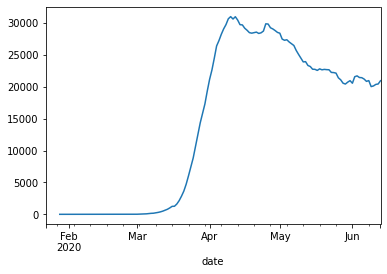

In [35]:
dfCovidtracking.groupby(by='date').sum().rolling(window=7).mean().positiveIncrease.plot.line()

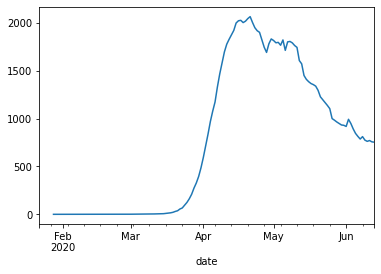

In [36]:
dfCovidtracking.groupby(by='date').sum().rolling(window=7).mean().deathIncrease.plot.line()

In [0]:
dfCAAvg = dfCovidtracking[dfCovidtracking.state=='CA'] \
.groupby(by='date').sum().rolling(window=7).mean()

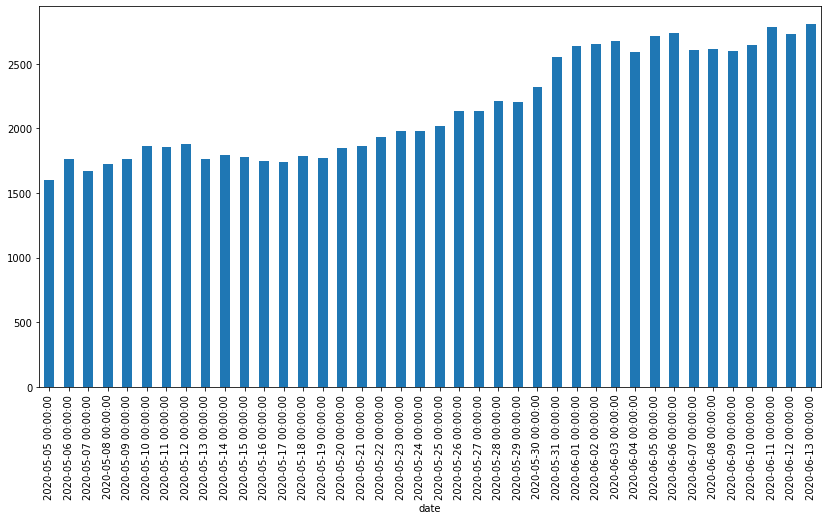

In [38]:

graph1 = dfCAAvg[-40:].positiveIncrease.plot.bar(figsize=(14,7))


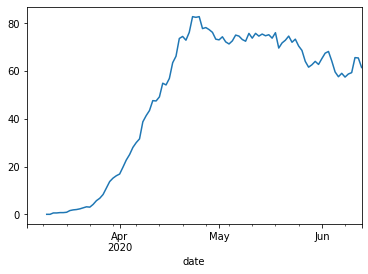

In [39]:
dfCAAvg.deathIncrease.plot.line()

In [40]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['GA']))].head(10)

,state,date,positive,death,total_positive,pct
1096,GA,2020-06-13,56801,2446,56801,1.000000
1097,GA,2020-06-12,55783,2418,56801,0.982078
1098,GA,2020-06-11,54973,2375,56801,0.967817
1099,GA,2020-06-10,53980,2329,56801,0.950335
1100,GA,2020-06-09,53249,2285,56801,0.937466
1101,GA,2020-06-08,52497,2208,56801,0.924227
1102,GA,2020-06-07,51898,2180,56801,0.913681
1103,GA,2020-06-06,51309,2174,56801,0.903312
1104,GA,2020-06-05,50621,2174,56801,0.891199
1105,GA,2020-06-04,49847,2147,56801,0.877573


In [41]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=7)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .85)].sort_values(by='pct')


,state,date,positive,death,total_positive,pct
396,AZ,2020-06-06,25451,1042,34458,0.738609
4385,SC,2020-06-06,13453,538,17955,0.749262
206,AR,2020-06-06,9101,154,11547,0.788170
2980,NC,2020-06-06,34625,992,42676,0.811346
107,AL,2020-06-06,20043,689,24601,0.814723
7,AK,2020-06-06,536,10,654,0.819572
4789,UT,2020-06-06,11798,121,13981,0.843860


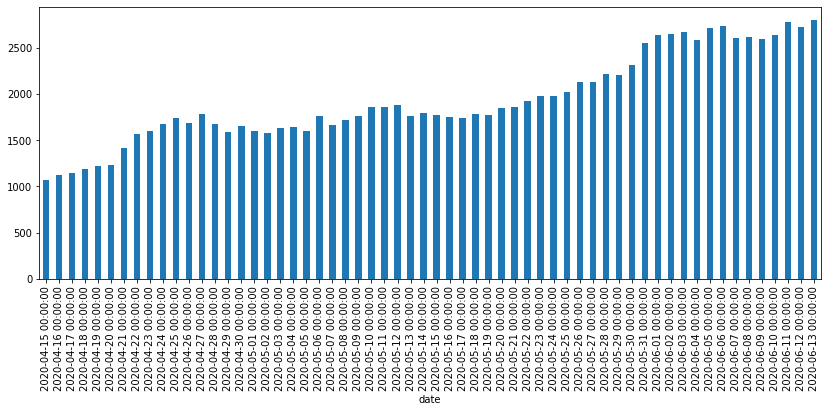

In [42]:

def showStateData(state):
  return dfCovidtracking[dfCovidtracking.state==state]\
  .sort_index()\
  .copy()



chart = showStateData('CA')\
.positiveIncrease\
.rolling(window=7)\
.mean()[-60:].plot.bar(figsize=(14,5))

In [43]:
dfTest = dfCovidtracking[dfCovidtracking.state=='CA'].sort_index().copy()
dfTest.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-04,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,0,0,515,515,0,515,0,0,da5ffc320e330912eb2bda98d99788210f19d9b0,0,0,0,0,0,
2020-03-05,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,0,0,515,515,0,515,0,0,9c56c71986f12d235538a29d11cd0f6b74c3fb62,0,0,0,0,0,
2020-03-06,CA,60,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,7,0,522,522,7,522,0,0,c4cb1d3cb8adf346e3e2fa0f88700667f007f331,0,0,0,0,0,
2020-03-07,CA,69,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,9,0,531,531,9,531,0,0,ab0f7583b4a081f1c7f18137c08161c4f4a5806e,0,0,0,0,0,
2020-03-08,CA,88,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,19,0,550,550,19,550,0,0,2f228f815b4535561a1b436cdd02c14547645345,0,0,0,0,0,


In [44]:
dfTest.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-04,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,0,0,515,515,0,515,0,0,da5ffc320e330912eb2bda98d99788210f19d9b0,0,0,0,0,0,
2020-03-05,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,0,0,515,515,0,515,0,0,9c56c71986f12d235538a29d11cd0f6b74c3fb62,0,0,0,0,0,
2020-03-06,CA,60,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,7,0,522,522,7,522,0,0,c4cb1d3cb8adf346e3e2fa0f88700667f007f331,0,0,0,0,0,
2020-03-07,CA,69,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,9,0,531,531,9,531,0,0,ab0f7583b4a081f1c7f18137c08161c4f4a5806e,0,0,0,0,0,
2020-03-08,CA,88,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,06,19,0,550,550,19,550,0,0,2f228f815b4535561a1b436cdd02c14547645345,0,0,0,0,0,


# State Population Data


In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [47]:
import math
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.index.max()][['positive', 'negative', 'pending','death', 'total']].sum()
cir = res.positive/res.total
cfr = res.death/res.positive
p_aff= math.ceil(us_pop*cir)
p_dead= math.ceil(p_aff*cfr)
print(res)
print(f"Current Infection Rate {cir*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Observed CFR: {cfr*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")
print(f"Projected affected by cir = {p_aff:,d}")
print(f"Projected killed = {p_dead:,d}")


positive     2063789
negative    20976515
pending         1698
death         109249
total       23042002
dtype: int64
Current Infection Rate 8.956639%
Percentage of US affected: 0.662028%
Observed CFR: 5.293613%
Percentage of US tested/affected: 7.052640%
Projected affected by cir = 29,399,231
Projected killed = 1,556,282


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.index.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [55]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.totalTestResults/ dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).\
             T.sort_values(by="state_pos_pop", ascending=False)[:50]

,state_pos_pop,state_test_pop
state,,
NY,1.966889,14.764598
NJ,1.875720,12.139067
MA,1.529125,10.208135
RI,1.505341,18.078634
DC,1.375702,8.931787
CT,1.262002,9.655716
DE,1.050460,8.225710
IL,1.047458,9.231554
MD,1.014030,6.761158


In [56]:
#print(f"Current Infection Rate {res.positive/res.total*100:2f}%")

print(f"Current Testing Percent {gbUSA.sum().tail(1).totalTestResults[0]/dfUSPop[dfUSPop.REGION=='0'].POPESTIMATE2019[0]*100:2f}%")

Current Testing Percent 7.019357%


In [57]:
dfJHUData.columns

Index(['FIPS', 'city', 'state', 'country', 'last_update', 'lat', 'lon',
       'confirmed', 'dead', 'recovered', 'active', 'key'],
      dtype='object')

# OWID Data

In [0]:
dfOwid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [0]:
dfOwidTests = dfOwid.dropna(subset=['total_tests']).copy()

In [0]:
dfOwidLatest = dfOwidTests.sort_values(by='date').groupby('iso_code').last()

In [61]:
dfOwidLatest.total_tests.sort_values(ascending=False)

iso_code
USA    23290724.0
RUS    14574117.0
IND     5507182.0
DEU     4694147.0
ITA     4564191.0
          ...    
BOL       42741.0
PRY       41702.0
MDV       32127.0
CRI       23224.0
ZWE       22805.0
Name: total_tests, Length: 84, dtype: float64

In [62]:
isUSA = dfOwidLatest.index.isin(['USA'])
NonUSTests = dfOwidLatest[~isUSA].total_tests.sum()
USTests = dfOwidLatest[isUSA].total_tests.sum()

print(f"Total testing done outside of USA: {NonUSTests:.0f}")
print(f"Total tests done in USA : {USTests:.0f}")
print(f"How many more times has the world tested more than the US: {NonUSTests/USTests:.1f}")

Total testing done outside of USA: 68332060
Total tests done in USA : 23290724
How many more times has the world tested more than the US: 2.9


In [63]:
dfOwidLatest[isUSA].sum()

continent                            North America
location                             United States
date                                    2020-06-12
total_cases                            2.02335e+06
new_cases                                    22883
total_deaths                                113820
new_deaths                                     896
total_cases_per_million                    6112.78
new_cases_per_million                       69.132
total_deaths_per_million                   343.864
new_deaths_per_million                       2.707
total_tests                            2.32907e+07
new_tests                                   871843
total_tests_per_thousand                    70.364
new_tests_per_thousand                       2.634
new_tests_smoothed                          415125
new_tests_smoothed_per_thousand              1.254
tests_units                        tests performed
stringency_index                             72.69
population                     

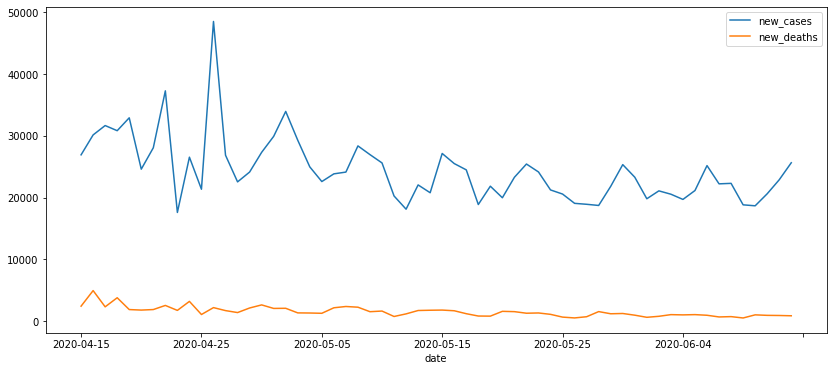

In [64]:
dfOwidUSA = dfOwid.loc[dfOwid.iso_code=='USA']

dfOwidUSA.set_index('date')[['new_cases','new_deaths']][-60:].plot.line(figsize=(14,6))

In [0]:
state = 'TX'
dfRollingWeekState = dfCovidtracking.loc[dfCovidtracking.state==state]\
.rolling(window=7).mean()


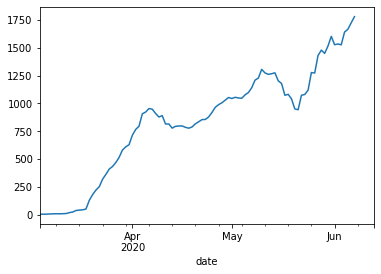

In [66]:
plt = dfRollingWeekState.positiveIncrease.plot.line()

In [67]:
dfJHUData[dfJHUData.state=='Florida'].confirmed.sum()

70971

In [0]:
doWGA = dfCovidtracking[dfCovidtracking.state=='GA'][['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']]\
.groupby(lambda x: x.dayofweek)

In [69]:
doWGA.sum()

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,346,1137,85445,6414,91859
1,543,1849,73088,8870,81958
2,415,1953,1832,9366,11198
3,395,1367,76270,8411,84681
4,379,1421,98849,9782,108631
5,231,1154,102210,7672,109882
6,137,343,105185,6284,111469


# Socrata (San Francisco) Data

In [70]:
!pip install sodapy

In [0]:
from sodapy import Socrata

In [0]:
client = Socrata("data.sfgov.org", "LCSuN5PrqWkGtBe9dULkS75Rz")
results_df = pd.DataFrame.from_records(client.get("tvq9-ec9w"))

In [0]:
res = results_df.astype({'case_count':'int16'}).rename(columns={'specimen_collection_date':'date'})


In [0]:
dfresConf = res[res.case_disposition=='Confirmed']
dfresDead = res[res.case_disposition=='Death']

In [0]:
dfTotals = dfresConf.groupby(by='date').sum().join(dfresDead.groupby(by='date').sum(), \
        rsuffix='dead').fillna(0) \
        .rename(columns={'case_count':'positive', 'case_countdead':'dead'})

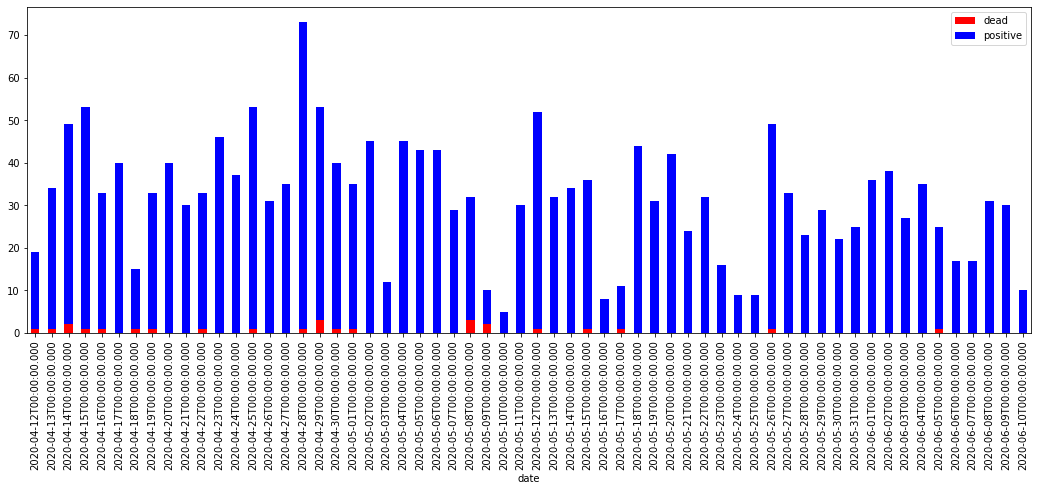

In [76]:
chart = dfTotals[['dead', 'positive']][-60:]\
.plot.bar(figsize=(18,6),stacked=True, color=['red','blue'])

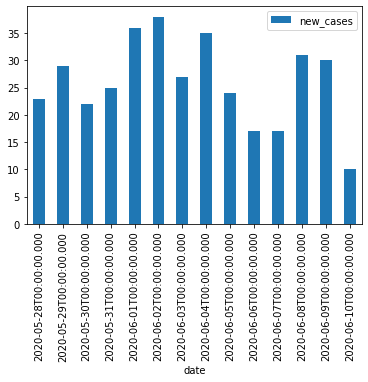

In [77]:
dfresConf.groupby('date').sum().rename(columns={'case_count':'new_cases'}).tail(14).plot.bar()

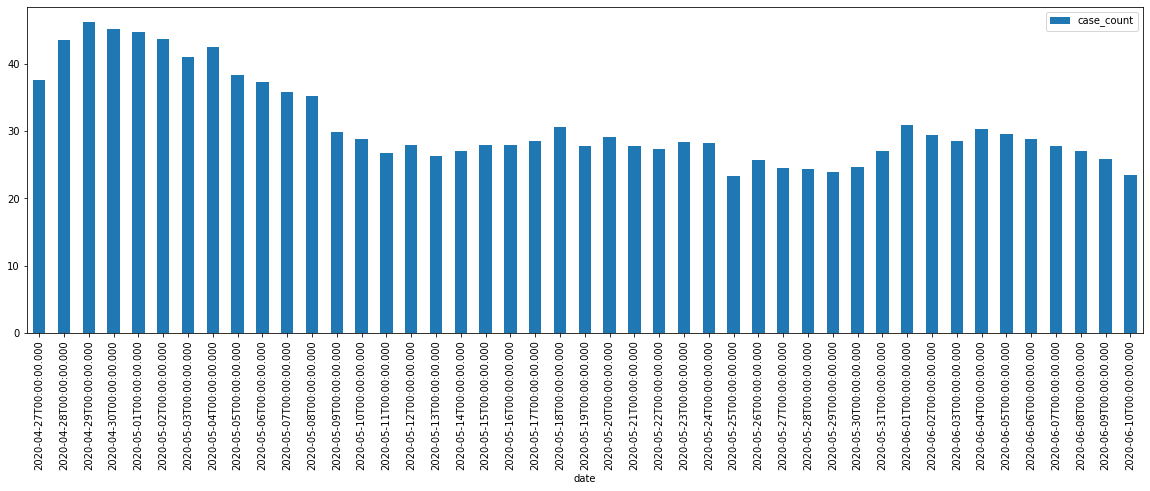

In [78]:
dfresConf.groupby('date').sum().rolling(window=7).mean()[-45:].plot.bar(figsize=(20,6))

# Marin Data

In [0]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSRmO2pStf7Ft1yYjDULluZXzUAczGK_B34hDemDBadGEY0HTLwlcadF2cHNEwmmvLetUTf-D2ruYCT/pub?gid=0&single=true&output=csv"

df = pd.read_csv(url, header=1, parse_dates=[0], usecols=[0,1,3,5,6,7], index_col=[0])

In [80]:
df.tail()

,positive,deaths,tested,hospitalizations,Recovered
date,,,,,
2020-06-08,610,17.0,16040.0,52.0,409.0
2020-06-09,620,17.0,16548.0,52.0,427.0
2020-06-10,635,17.0,17032.0,52.0,434.0
2020-06-11,648,17.0,17367.0,49.0,463.0
2020-06-12,676,17.0,17425.0,51.0,487.0


In [81]:
df[['deaths','positive']].diff()

,deaths,positive
date,,
2020-03-06,NaN,NaN
2020-03-07,0.0,0.0
2020-03-08,0.0,1.0
2020-03-09,0.0,0.0
2020-03-10,NaN,0.0
...,...,...
2020-06-08,0.0,21.0
2020-06-09,0.0,10.0
2020-06-10,0.0,15.0


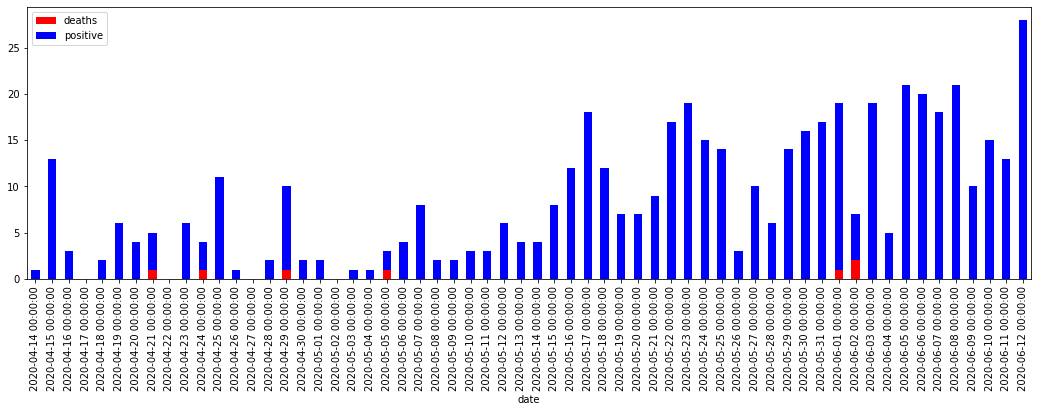

In [82]:
chart= df[['deaths','positive']].diff()[-60:]\
.plot.bar(stacked=True,figsize=(18,5), color=['r','b'])

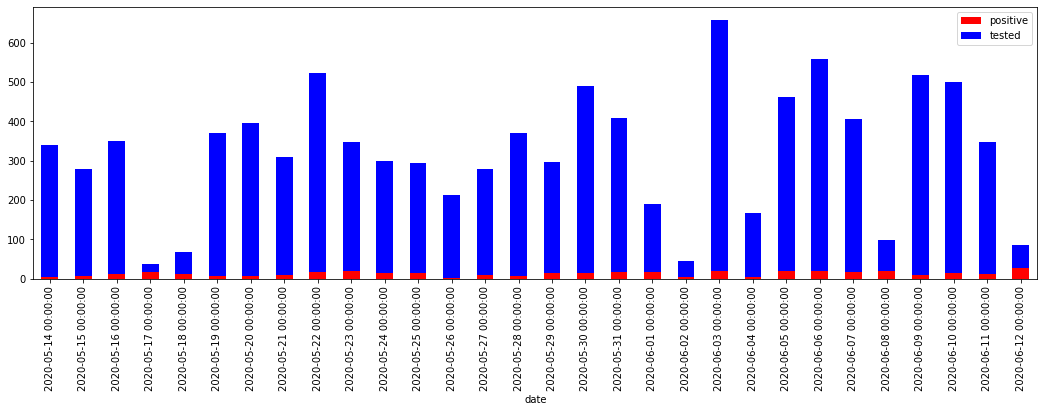

In [83]:
chart= df[['positive','tested']].diff()[-30:]\
.plot.bar(stacked=True,figsize=(18,5), color=['r','b'])

In [84]:
(df.positive.diff()/df.tested.diff()).rolling(window=7).mean()[-14:]

date
2020-05-30    0.036288
2020-05-31    0.034923
2020-06-01    0.042644
2020-06-02    0.058908
2020-06-03    0.057825
2020-06-04    0.059880
2020-06-05    0.059625
2020-06-06    0.060103
2020-06-07    0.060534
2020-06-08    0.084132
2020-06-09    0.068629
2020-06-10    0.068809
2020-06-11    0.069943
2020-06-12    0.132121
dtype: float64

In [85]:
df.positive.diff()[-1]/df.tested.diff()[-1]

0.4827586206896552

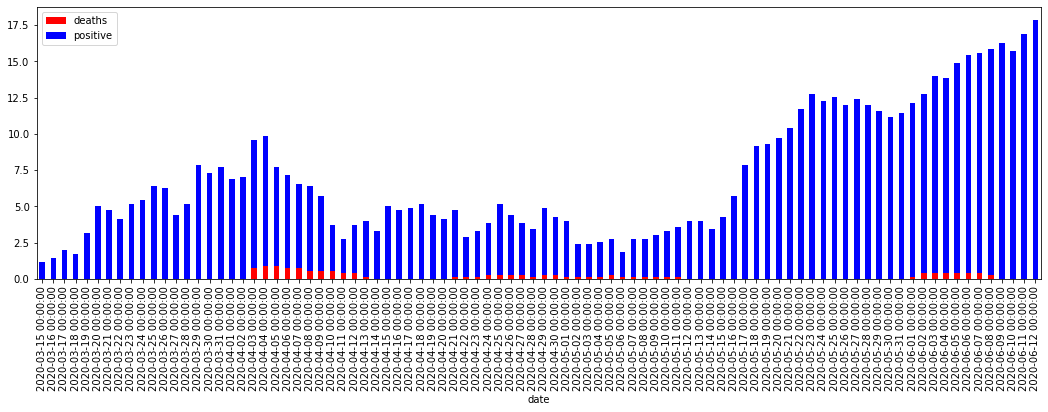

In [86]:
chart= df[['deaths','positive']].diff()\
.rolling(window=7).mean()[-90:]\
.plot.bar(stacked=True,figsize=(18,5), color=['r','b'])

In [87]:
marin_pop = 259725

print(f"Marin Population Positive: {(df[-1:].positive.values[0]/marin_pop)*100:2.2f}%")
print(f"Marin Population Tested: {(df[-1:].tested.values[0]/marin_pop)*100:2.2f}%")

Marin Population Positive: 0.26%
Marin Population Tested: 6.71%


In [88]:
df.positive.diff().rolling(window=7).mean().tail()

date
2020-06-08    15.571429
2020-06-09    16.285714
2020-06-10    15.714286
2020-06-11    16.857143
2020-06-12    17.857143
Name: positive, dtype: float64

In [89]:
dfCovidtracking[dfCovidtracking.state=='CA'].head(28)[::-1].positive.diff()


date
2020-05-17       NaN
2020-05-18    1591.0
2020-05-19    1365.0
2020-05-20    2262.0
2020-05-21    2140.0
2020-05-22    2247.0
2020-05-23    2187.0
2020-05-24    2079.0
2020-05-25    1848.0
2020-05-26    2175.0
2020-05-27    2247.0
2020-05-28    2717.0
2020-05-29    2189.0
2020-05-30    2992.0
2020-05-31    3705.0
2020-06-01    2423.0
2020-06-02    2304.0
2020-06-03    2377.0
2020-06-04    2120.0
2020-06-05    3094.0
2020-06-06    3115.0
2020-06-07    2796.0
2020-06-08    2507.0
2020-06-09    2170.0
2020-06-10    2702.0
2020-06-11    3090.0
2020-06-12    2702.0
2020-06-13    3660.0
Name: positive, dtype: float64